In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVR
import numpy as np

In [2]:
df=pd.read_csv('NIFTY_50.csv',parse_dates=['Date'])
df['Date']=pd.to_datetime(df['Date'])
# Create features for prediction
"""Create technical indicators as features"""
# Simple moving averages
df['SMA5'] = df['Close'].rolling(window=5).mean()
df['SMA20'] = df['Close'].rolling(window=20).mean()
    
# Price difference (Close - Open)
df['Price_Diff'] = df['Close'] - df['Open']
    
# Volatility (High - Low)
df['Volatility'] = df['High'] - df['Low']
    
# Remove rows with NaN values
df.dropna(inplace=True)
    


In [3]:
"""Prepare data for SVM model"""
feature_cols = ['Open', 'High', 'Low', 'SMA5', 'SMA20', 'Price_Diff', 'Volatility']
target_col=['Close']
# Extract features and target
X = df[feature_cols].values
y = df[target_col].values
    
# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
    
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [5]:
param_distributions = {
    'C': np.logspace(-3, 3, 10),        # Log-spaced values from 0.001 to 1000
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 2, 6)),  # Log-spaced values + 'scale' and 'auto'
    'epsilon': np.logspace(-3, 0, 10),  # Log-spaced values from 0.001 to 1
    'degree': [2, 3, 4]                 # Only relevant for poly kernel
}


In [6]:
random_search = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=param_distributions,
    n_iter=30,             # Number of parameter settings sampled (much less than full grid)
    cv=5,                  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Metric to optimize (negative MSE for regression)
    n_jobs=-1,             # Use all available cores
    verbose=1,             # Display progress
    random_state=42        # For reproducibility
)

In [7]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=30, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                                        'degree': [2, 3, 4],
                                        'epsilon': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'gamma': ['scale', 'auto',
                                                  np.float64(0.001),
                                                  np.float64(0.01),
                                                  np.float64(0.1),
                                                  np.float64(1.0),
                                                  np.float64(10.0),
                                                  np.float64(100.0)],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [8]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation MSE: {-random_search.best_score_:.6f}")

Best parameters: {'kernel': 'linear', 'gamma': np.float64(1.0), 'epsilon': np.float64(0.001), 'degree': 4, 'C': np.float64(10.0)}
Best cross-validation MSE: 0.000000


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict and invert scale
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate errors
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 5.876482695678617
RMSE: 6.478515201170898


In [10]:
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

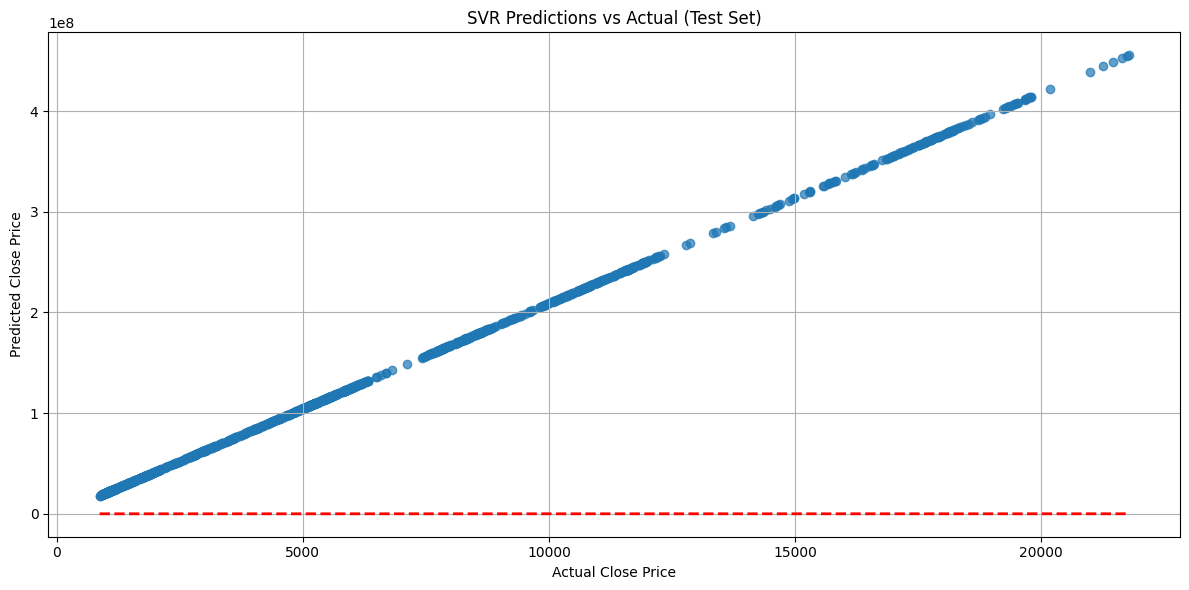

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.7)
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], 
         'r--', lw=2)
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('SVR Predictions vs Actual (Test Set)')
plt.grid(True)
plt.tight_layout()
plt.show()